<a href="https://colab.research.google.com/github/islam-mirajul/YouTube-Exaggerated-Bangla-Titles-Categorization/blob/main/YouTube-Exaggerated-Bangla-Titles-Categorization(CNN-2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [ ]:

def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [ ]:

# reading data
df = pd.read_csv('/content/drive/MyDrive/youtube project/youtubeRD-csv.csv')
print(df.columns)
print('No. of unique classes',len(set(df['Type'])))

Index(['Title', 'Type'], dtype='object')
No. of unique classes 2


In [ ]:
macronum=sorted(set(df['Type']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['Type']=df['Type'].apply(fun)

In [ ]:
texts = []
labels = []


for idx in range(df.Title.shape[0]):
    text = BeautifulSoup(df.Title[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in df['Type']:
    labels.append(idx)

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 5078


In [ ]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]


Shape of Data Tensor: (1799, 1000)
Shape of Label Tensor: (1799, 2)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2021-04-01 15:42:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-01 15:42:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-01 15:42:58--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove

In [ ]:
!unzip glove*.zip
!ls
!pwd

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
drive		   glove.6B.300d.txt  glove.6B.zip.1
glove.6B.100d.txt  glove.6B.50d.txt   glove.6B.zip.2
glove.6B.200d.txt  glove.6B.zip       sample_data
/content


In [ ]:

embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [ ]:

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         507900    
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)    

In [ ]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

Epoch 1/15
720/720 [==============================] - 19s 25ms/step - loss: 0.7414 - acc: 0.5190 - val_loss: 0.5752 - val_acc: 0.6825

Epoch 00001: val_acc improved from -inf to 0.68245, saving model to model_cnn.hdf5
Epoch 2/15
720/720 [==============================] - 17s 24ms/step - loss: 0.6288 - acc: 0.6668 - val_loss: 0.5949 - val_acc: 0.7159

Epoch 00002: val_acc improved from 0.68245 to 0.71588, saving model to model_cnn.hdf5
Epoch 3/15
720/720 [==============================] - 18s 24ms/step - loss: 0.5695 - acc: 0.7358 - val_loss: 0.5145 - val_acc: 0.7437

Epoch 00003: val_acc improved from 0.71588 to 0.74373, saving model to model_cnn.hdf5
Epoch 4/15
720/720 [==============================] - 18s 24ms/step - loss: 0.4571 - acc: 0.8057 - val_loss: 0.5919 - val_acc: 0.7604

Epoch 00004: val_acc improved from 0.74373 to 0.76045, saving model to model_cnn.hdf5
Epoch 5/15
720/720 [==============================] - 18s 24ms/step - loss: 0.3976 - acc: 0.8496 - val_loss: 0.7106 - v

In [ ]:
score = model.evaluate(x_train, y_train,
                       batch_size=2, verbose=2)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

720/720 - 4s - loss: 0.0144 - acc: 0.9958
Train loss: 0.01437106542289257
Train accuracy: 0.9958333373069763


In [ ]:
score = model.evaluate(x_val, y_val,
                       batch_size=2, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

180/180 - 1s - loss: 1.6228 - acc: 0.7103
Test loss: 1.6228331327438354
Test accuracy: 0.7103064060211182


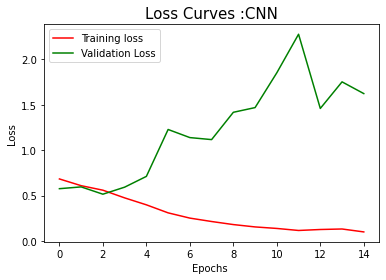

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=1.5)
plt.plot(history.history['val_loss'],'g',linewidth=1.5)
plt.legend(['Training loss', 'Validation Loss'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.title('Loss Curves :CNN',fontsize=15)
plt.show()

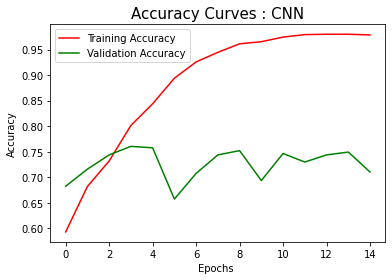

In [ ]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=1.5)
plt.plot(history.history['val_acc'],'g',linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=10)
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
plt.title('Accuracy Curves : CNN',fontsize=15)
plt.show()